# Imports and mounting drive

In [3]:
#library imports
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
import argparse
import shutil

from lxml import etree
from tqdm import tqdm

import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

import torchvision
import seaborn as sns
from PIL import Image, ImageDraw

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
image_directory = "/content/drive/MyDrive/DataSet/task_felipe-2021_08_30_18_24_03-cvat for images 1.1/images"
annotations_directory = "/content/drive/MyDrive/DataSet/task_felipe-2021_08_30_18_24_03-cvat for images 1.1/annotations.xml"

# Pre-Processing

## Create data frame of annotations

Since we are using custom data and a custom image labeler, we wrote our own parser. We are only worried about the "seed bounding boxes" for this project

Goal: Parse XML file with labels into a dataframe

In [6]:
#XML parser 
#One XML contains all the images annotation. 
#This parser creates a list of dictionaries containing the image name with the coordinates of the bounding box of the seed. 
root = etree.parse(annotations_directory).getroot()
anno = []
image_info = {}

for image in root.iter('image'):
  #print(image.attrib)
  image_name = image.attrib['name']
  image_width = image.attrib['width']
  image_height = image.attrib['height']
  #print(image_name)
  #image_info = {'name':image_name}

  for box in image.findall('box'):
    if box.attrib['label'] == 'Seed':
      #print(box.items())
      
      for key, value in box.items():
        image_info['name'] = image_name
        image_info['width'] = image_width
        image_info['height'] = image_height
        image_info[key] = value
        #print(image_info.keybs())
      #print(image_info)
      
      #print(anno)
      anno.append(image_info)
      image_info = {} 

In [7]:
#Creates a dataframe out of the list of dictionaries
width = []
height = []
image_name = []
labels =[]
xtl = []
ytl = []
xbr = []
ybr = []

for item in anno:
  #print(item.keys())
  image_name.append(item['name'])
  width.append(item['width'])
  height.append(item['height'])
  labels.append(0)
  xtl.append(float(item['xtl']))
  ytl.append(float(item['ytl']))
  xbr.append(float(item['xbr']))
  ybr.append(float(item['ybr']))

df = pd.DataFrame(list(zip(image_name, width, height, labels, xtl, ytl,xbr,ybr)),
               columns =['Name','width', 'height', 'Label', 'xmin', 'ymin','xmax','ymax'])


In [8]:
df.head(3)

Name width  ...    xmax     ymax
0  Images_Bulk_Labeling/SET5/image_sensorid_4_fra...  1086  ...  478.03   814.79
1  Images_Bulk_Labeling/SET5/image_sensorid_4_fra...  1086  ...  511.11   795.35
2  Images_Bulk_Labeling/SET5/image_sensorid_4_fra...  1086  ...  493.02  1160.08

[3 rows x 8 columns]

In [9]:
df_train = df

## Sample Image with Bounding Box

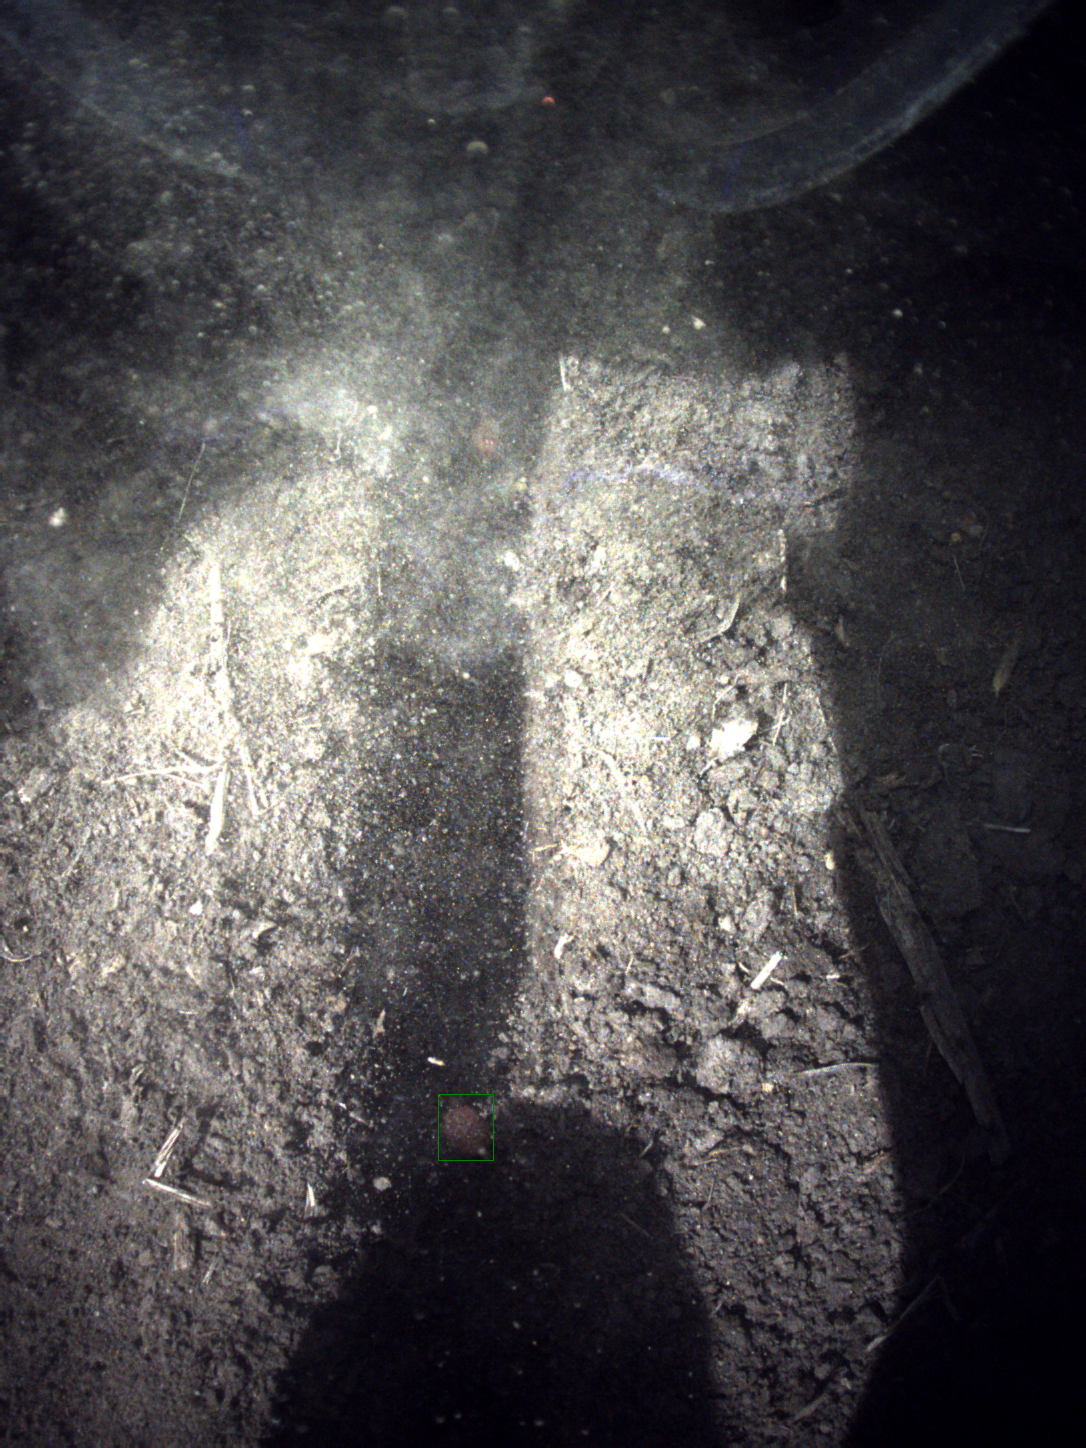

In [10]:
# Show sample image
sample_image = Image.open(image_directory + '/' + anno[2]['name'])
box_coor = [float(anno[2]['xtl']), float(anno[2]['ytl']), float(anno[2]['xbr']), float(anno[2]['ybr'])]
img_bbox = ImageDraw.Draw(sample_image)
img_bbox.rectangle(box_coor, outline="green") 

sample_image

In [11]:
df.shape

(2006, 8)

## Image Mask

Goal: Show mask from bounding box. This was created as a sanity check to make sure that our bounding boxes imported correctly.

In [12]:
# Code source: https://towardsdatascience.com/bounding-box-prediction-from-scratch-using-pytorch-a8525da51ddc
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[5],x[4],x[7],x[6]])

## Sample Image with Mask

In [13]:
# im = cv2.imread(str(df_train.values[58][8]))
im = cv2.imread( image_directory + '/' + str(df_train.values[58][0]))
bb = create_bb_array(df_train.values[58])
print(bb)
print(im.shape)

[281.58 445.68 347.27 484.7 ]
(1448, 1086, 3)


In [14]:
Y = create_mask(bb, im)
mask_to_bb(Y)

array([281., 445., 346., 483.], dtype=float32)

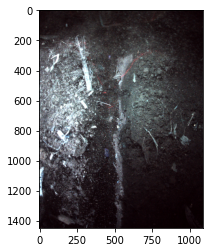

In [15]:
plt.imshow(im)

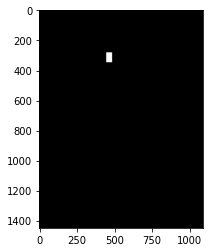

In [16]:
plt.imshow(Y, cmap='gray')

# Resizng Images and Bounding Boxes

In [35]:
#Reading an image
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [36]:
def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (sz, int(0.75*sz)))
    Y_resized = cv2.resize(create_mask(bb, im), (sz, int(0.75*sz)))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    
    return new_path, mask_to_bb(Y_resized)

In [ ]:
#Populating Training DF with new paths and bounding boxes
new_paths = []
new_bbs = []
train_path_resized = Path('/content/drive/MyDrive/Colab Notebooks/DataSet/images_resized')
for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(Path(image_directory + '/' + row['Name']), train_path_resized, create_bb_array(row.values), 600)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

# Generating Dataset

Goal: From out custom data set, we need to create a training data set to be able to input it to the py_torch data loader. In this case, we used our dataframe as input.

The py_torch documentation requires us to create the following methods:

__inint__

__getitem__

__len__

This class was inspired by a project in which the author used the model to detect faces

Reference: https://blog.francium.tech/object-detection-with-faster-rcnn-bc2e4295bf49

In [17]:
class TrainDataset(Dataset):
  def __init__(self, annotation_dataframe):
      self.train_df = annotation_dataframe
      self.image_ids = self.train_df['Name']

  def __getitem__(self, index):
      image_id = self.image_ids[index]
      bboxes = self.train_df[self.train_df['Name'] == image_id]

      image = cv2.imread(image_directory + "/" + image_id, cv2.IMREAD_COLOR)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
      image /= 255.0 # Apply normalization

      boxes = bboxes[['xmin', 'ymin', 'xmax', 'ymax']].values
      area = (boxes[:,3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

      boxes = torch.as_tensor(boxes, dtype=torch.float32)
      area = torch.as_tensor(area, dtype = torch.float32)

      labels = torch.ones((bboxes.shape[0],), dtype = torch.int64)
      iscrowd = torch.zeros((bboxes.shape[0],), dtype = torch.int64)

      target = {}
      target['boxes'] = boxes
      target['labels'] = labels
      target['image_id'] = torch.tensor([index])
      target['area'] = area
      target['iscrowd'] = iscrowd

      image = torchvision.transforms.ToTensor()(image)
      return image, target

  def __len__(self) -> int:
      return self.image_ids.shape[0]

  

It is now possible to use Py_torch's dataloader to load our custom dataset with tensors

In [18]:
# Initialize Dataset
train_dataset = TrainDataset(df_train)

def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

Use GPU is available

In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Plot bounding box from our dataloader. Sanity check to see if data is still aligned

<Element box at 0x7fc168ffdb90>
(1448, 1086, 3)


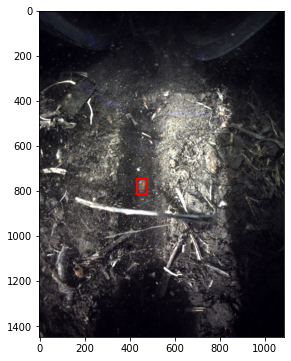

In [20]:
import matplotlib.patches as patches
images, targets = next(iter((train_data_loader)))
images = list(image.to(device) for image in images)
targets = [{k : v.to(device) for k, v in t.items()} for t in targets]

boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
img = images[0].permute(1,2,0).cpu().numpy()
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.imshow(img)

print(box)
box = boxes[0]
rect = patches.Rectangle((box[0], box[1]), box[2] -  box[0], box[3] - box[1], linewidth = 2, edgecolor = 'r', facecolor = 'none')
ax.add_patch(rect)
print(img.shape)


# Data Augumentation

In [ ]:
# modified from fast.ai
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

In [ ]:
# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

In [ ]:
def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

In [ ]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

In [ ]:
def random_cropXY(x, Y, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

In [ ]:
def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [ ]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

In [ ]:
def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

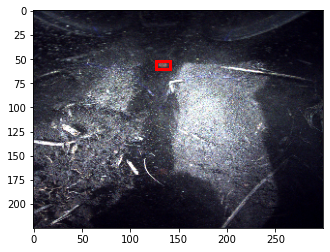

In [ ]:
#original
im = cv2.imread(str(df_train.values[68][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train.values[68][9])

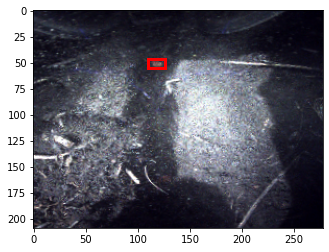

In [ ]:
# after transformation
im, bb = transformsXY(str(df_train.values[68][8]),df_train.values[68][9],True )
show_corner_bb(im, bb)

# Initializing model

We are using fasterRCNN deep convolutional network. This is a standard for object detection with fast training speeds and good accuracy. Since we are training images never seen before, we cannot use a pretrained model. Our references mostly used Fast RCNN as well, therefore we deficed to attempt to use that model

The resnet50 backbone allowed us to use an amount of layers that sounded reasonable given the small amount of features we need to extract (only worried about the seed in the image)

In [21]:
# Declare our model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = False)
# Learn seed and background
num_classes = 2
# Create box predictor - Goal: predict bounding box around seed
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

We will be using Stochastic Gradient Descent for our loss with an added momentum of 0.9 and weight decay of 0.0005. Due to time constraints we followed the values used by our reference.

Reference: https://blog.francium.tech/object-detection-with-faster-rcnn-bc2e4295bf49

In [24]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 5

Transfer model to CUDA

In [23]:
if torch.cuda.is_available():
    model.cuda()

# Train

In [25]:
model.train()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [26]:
itr = 1

for epoch in range(num_epochs):
  for images, targets in train_data_loader:
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k , v in t.items()} for t in targets]
    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict. values())
    loss_value = losses.item()

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    if itr % 50 == 0:
      print(f"Iteration #{epoch} loss:{loss_value}")
    itr += 1

    lr_scheduler.step()

  print(f"Epoch #{epoch} loss: {loss_value}")

torch.save(model.state_dict(), 'model.pth')
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict' : optim.state_dict()
}, 'ckpt.pth')

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Iteration #0 loss:0.8099243640899658
Iteration #0 loss:0.811672031879425
Iteration #0 loss:0.7972904443740845
Iteration #0 loss:0.8261403441429138
Iteration #0 loss:0.8077552318572998
Iteration #0 loss:0.8430716395378113
Iteration #0 loss:0.8749362230300903
Iteration #0 loss:0.8391685485839844
Iteration #0 loss:0.8464017510414124
Iteration #0 loss:0.781330943107605
Iteration #0 loss:0.8208565711975098
Iteration #0 loss:0.8229580521583557
Iteration #0 loss:0.8526983857154846
Iteration #0 loss:0.854676365852356
Iteration #0 loss:0.8707254528999329
Iteration #0 loss:0.9648164510726929
Iteration #0 loss:0.8363792896270752
Iteration #0 loss:0.8153494596481323
Iteration #0 loss:0.7672658562660217
Iteration #0 loss:0.8165495991706848
Epoch #0 loss: 0.7897543907165527
Iteration #1 loss:0.7734297513961792
Iteration #1 loss:0.8152816295623779
Iteration #1 loss:0.7998712062835693
Iteration #1 loss:0.8246209025382996
Iteration #1 loss:0.7774640917778015
Iteration #1 loss:0.8489465713500977
Iterati

AttributeError: ignored

In [27]:
torch.save(model.state_dict(), 'model.pth')
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict' : optimizer.state_dict()
}, 'ckpt.pth')

# TestDataset

In [41]:
from google.colab.patches import cv2_imshow
image_dir = '/content/drive/MyDrive/DataSet/test_dataset/'
image_ids = [fl for fl in list(sorted(os.listdir(image_dir))) if 'png' in fl]
image_dir = image_dir
index = 0
image_id = image_ids[index]
image = cv2.imread(f'{image_dir}{image_id}', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0

image = torchvision.transforms.ToTensor()(image)
print(image)
len(image_ids)

tensor([[[0.0118, 0.0118, 0.0118,  ..., 0.0000, 0.0000, 0.0000],
         [0.0118, 0.0118, 0.0118,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0118,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0235, 0.0235, 0.0275,  ..., 0.0000, 0.0000, 0.0000],
         [0.0431, 0.0431, 0.0314,  ..., 0.0000, 0.0000, 0.0000],
         [0.0431, 0.0431, 0.0314,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0275, 0.0275, 0.0118,  ..., 0.0000, 0.0000, 0.0000],
         [0.0275, 0.0275, 0.0118,  ..., 0.0000, 0.0000, 0.0000],
         [0.0118, 0.0118, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0157,  ..., 0.0000, 0.0000, 0.0000],
         [0.0157, 0.0157, 0.0275,  ..., 0.0000, 0.0000, 0.0000],
         [0.0157, 0.0157, 0.0275,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0431, 0.0431, 0.0314,  ..., 0.0235, 0.0314, 0.0314],
         [0.0431, 0.0431, 0.0314,  ..., 0.0235, 0.0314, 0.0314],
         [0.0471, 0.0471, 0.0392,  ..., 0.0157, 0.0275, 0.

22

In [44]:
class TestDataset(Dataset):
  def __init__(self, image_dir):
    super().__init__()
    
    self.image_ids = [fl for fl in list(sorted(os.listdir(image_dir))) if 'png' in fl]
    self.image_dir = image_dir
  
  def __getitem__(self, index : int):
    image_id = self.image_ids[index]
    image = cv2.imread(f'{self.image_dir}{image_id}', cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0

    image = torchvision.transforms.ToTensor()(image)

    return image

  def __len__(self) -> int:
    return len(self.image_ids)

In [51]:
test_dataset = TestDataset('/content/drive/MyDrive/DataSet/test_dataset/')
test_data_loader = DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,
)

In [46]:
model.load_state_dict(torch.load('./model.pth'))
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [47]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [48]:
import gc
obj = None
gc.collect()

torch.cuda.empty_cache() # PyTorch thing

0.42947605
0.4042666
0.40164846
0.39965776
0.3971414
0.39560804
0.3945776
0.3904819
0.38924482
0.38676605
0.38546208
0.38361353
0.3830011
0.38100412
0.3800328
0.37992215
0.3796883
0.37501258
0.3720851
0.37193632
0.37098888
0.3669859
0.36664307
0.36605898
0.36583254
0.36192074
0.3609818
0.3608118
0.35949898
0.35767895
0.355162
0.34995452
0.34770492
0.3475998
0.34667495
0.34470916
0.33702496
0.33394182
0.33066696
0.3275782
0.3254017
0.32332346
0.320772
0.3190351
0.3165442
0.3151159
0.31441066
0.30978063
0.30693474
0.30646572
0.304544
0.30362037
0.30361953
0.30212516
0.29869118
0.29484496
0.29471794
0.29217395
0.2912528
0.29110003
0.28943074
0.2892082
0.28823963
0.28723675
0.28585905
0.28481588
0.28191215
0.2780031
0.27403852
0.27342254
0.26962548
0.26600754
0.26395765
0.24226108
0.23883541
0.16121282
0.15200655
0.15178025
0.14575292
0.13467184
0.13143192
0.12936543
0.121638194
0.12106067
0.11795791
0.114929035
0.11427529
0.11118695
0.110803515
0.10965849
0.10887559
0.10703545
0.106119744

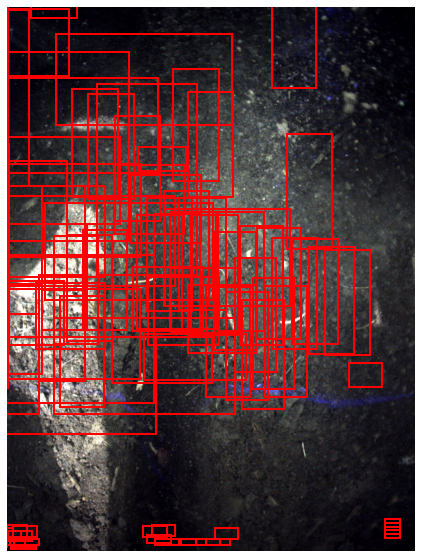

In [52]:
from posix import sched_param
images = next(iter((test_data_loader)))
images = list(image.to(device) for image in images)


outputs = model(images)

index = 0
img = images[index].permute(1,2,0).cpu().numpy()
boxes = outputs[index]['boxes'].data.cpu().numpy()
scores = outputs[index]['scores'].data.cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(20, 10))

ax.imshow(img)

counter = 0
for box in boxes:
  rect = patches.Rectangle((box[0], box[1]), - (box[2] -  box[0]), -(box[3] - box[1]), linewidth = 2, edgecolor = 'r', facecolor = 'none')
  ax.add_patch(rect)
  print(scores[counter])
  counter += 1
print(img.shape)
ax.set_axis_off()
ax.imshow(img)


[ 155.82524   116.177765 1086.        608.9218  ]
458338.06
[ 381.5906   509.88153 1086.      1233.4531 ]
509690.66
[ 176.96764  245.14476  674.35925 1240.9318 ]
495296.1
[  0.      365.915   712.5956  874.28973]
362265.6
[428.34302   23.522842 677.31616  533.52185 ]
126976.06
[230.65453    3.761534 721.327    768.1702  ]
375074.3
[  0.       98.34502 564.4086  578.46216]
270982.25
[239.22734     1.8021089 484.5508    483.3336   ]
118130.97
[  80.92146  874.5466  1086.      1367.6415 ]
495599.12
[514.7587 801.954  762.1277 928.4083]
31280.879
[ 695.438    614.12775 1032.7592   974.2403 ]
121473.586
[ 400.3409 1215.3557  517.2637 1448.    ]
27201.412
[6.7164838e+02 1.0625781e+00 1.0860000e+03 9.8446857e+02]
407475.88
[   0.      861.7956  605.9021 1364.974 ]
304876.84
[339.63315  93.84472 823.59033 346.5051 ]
122276.805
[390.59982 440.72348 571.13196 618.5903 ]
32110.672
[241.76091 144.00333 711.63275 400.61975]
120576.83
[447.02747 279.26416 921.8422  535.48755]
121658.65
[ 563.7027   

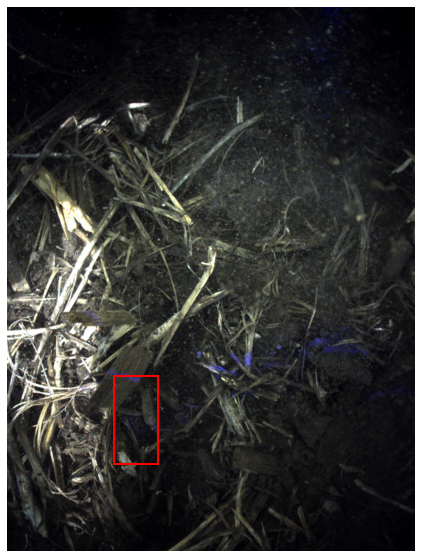

In [58]:
from posix import sched_param
images = next(iter((test_data_loader)))
images = list(image.to(device) for image in images)


outputs = model(images)

index = 1
img = images[index].permute(1,2,0).cpu().numpy()
boxes = outputs[index]['boxes'].data.cpu().numpy()
scores = outputs[index]['scores'].data.cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(20, 10))

ax.imshow(img)

counter = 0
for box in boxes:
  if counter > 30:
    continue
  print(boxes[counter])
  print((abs(box[0] - box[2]) * abs(box[1] - box[3])) )
  if ((abs(box[0] - box[2]) * abs(box[1] - box[3])) > 30000):
    counter += 1
    continue
  rect = patches.Rectangle((box[0], box[1]), - (box[2] -  box[0]), -(box[3] - box[1]), linewidth = 2, edgecolor = 'r', facecolor = 'none')
  ax.add_patch(rect)
  # print(scores[counter])
  counter += 1

print(img.shape)
ax.set_axis_off()
ax.imshow(img)